# Twitter Sentiment Analysis
Ming Fong

Linguistics 55AC

Useful: https://medium.com/swlh/coronavirus-python-tutorial-1-520cc960aac1

In [1]:
import tweepy #https://github.com/tweepy/tweepy
import csv
from secrets import *
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
consumer_key = api_key
consumer_secret = api_secret
access_key = access_token
access_secret = access_secret

In [3]:
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name, count = 200)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print(f"getting tweets before {oldest}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name, count=200, max_id = oldest)
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"...{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text] for tweet in alltweets]
    
    #write the csv  
    # with open(f'data/{screen_name}_tweets.csv', 'w') as f:
    #     writer = csv.writer(f)
    #     writer.writerow(["id","created_at","text"])
    #     writer.writerows(outtweets)
    
    return outtweets


In [4]:
data = pd.DataFrame(get_all_tweets("realDonaldTrump"))

getting tweets before 1335467089830825983
...400 tweets downloaded so far
getting tweets before 1333207778643628031
...600 tweets downloaded so far
getting tweets before 1329963571250335743
...798 tweets downloaded so far
getting tweets before 1327708998662025215
...997 tweets downloaded so far
getting tweets before 1325442345396039679
...1197 tweets downloaded so far
getting tweets before 1323030575410778117
...1397 tweets downloaded so far
getting tweets before 1321901910933188607
...1597 tweets downloaded so far
getting tweets before 1320690788628598783
...1797 tweets downloaded so far
getting tweets before 1319043691017850888
...1996 tweets downloaded so far
getting tweets before 1317051578872889344
...2193 tweets downloaded so far
getting tweets before 1315809747677843455
...2392 tweets downloaded so far
getting tweets before 1314282615516651519
...2591 tweets downloaded so far
getting tweets before 1311859538279239685
...2790 tweets downloaded so far
getting tweets before 1310436

In [5]:
df = data.copy()
df.columns = ["id", "date", "text"]
# Remove links
df["text"] = [re.sub(r'https?://\S+', '', str(x)) for x in df["text"]]
# Remove Retweets
df = df[~df["text"].str.startswith("RT @")]
df["text"] = df["text"].replace("", np.nan)
df = df.dropna(subset = ["text"])

# Remove non alphanumeric characters
# df["text"] = [" ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", x).split()) for x in df["text"]]

In [6]:
df

,id,date,text
0,1338352220614635520,2020-12-14 05:16:49,A great honor!
3,1338348880182829061,2020-12-14 05:03:33,What a fool Governor @BrianKempGA of Georgia i...
4,1338347204440952832,2020-12-14 04:56:53,Democrats weakened the Signature Verification ...
5,1338327779956363265,2020-12-14 03:39:42,Oh no! What is going on? This is not good news...
6,1338325735778476035,2020-12-14 03:31:34,People working in the White House should recei...
...,...,...,...
3201,1306224783705735170,2020-09-16 13:33:51,Great News: BIG TEN FOOTBALL IS BACK. All team...
3205,1306219979566710784,2020-09-16 13:14:46,China is drooling. They can’t believe this!
3207,1306218571765297152,2020-09-16 13:09:10,“Cratered”. We have plenty of politics to go a...
3211,1306084770300997632,2020-09-16 04:17:29,What is this all about?


In [7]:
post_election = df[df["date"] >= "2020-11-3"]
pre_election = df[df["date"] < "2020-11-3"]

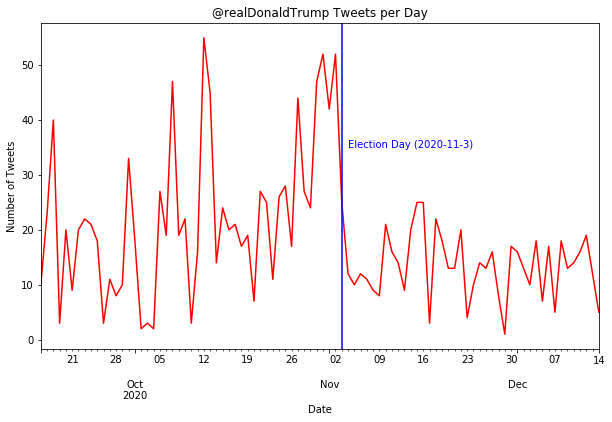

In [18]:
# Plot tweets per day
df["date truncated"] = [x.replace(minute = 0, hour = 0, second = 0, microsecond = 0) for x in df["date"]]
df.groupby(df["date truncated"]).count()["id"].plot(color = "red", figsize = (10, 6))
plt.axvline(x = dt.datetime(2020, 11, 3), color = "blue")
plt.text(dt.datetime(2020, 11, 4), 35, "Election Day (2020-11-3)", color = "blue")
plt.title("@realDonaldTrump Tweets per Day")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.savefig("images/tweets_per_day")

In [15]:
print("Mean tweets per day pre-election: " + str(pre_election.groupby(df["date truncated"]).count().mean()))
print("Mean tweets per day post-election: " + str(post_election.groupby(df["date truncated"]).count().mean()))

Mean tweets per day pre-election: id      22.354167
date    22.354167
text    22.354167
dtype: float64
Mean tweets per day post-election: id      13.619048
date    13.619048
text    13.619048
dtype: float64


In [201]:
# Sentiment score for each tweet
df["sentiment"] = [TextBlob(text).sentiment.polarity for text in df["text"]]

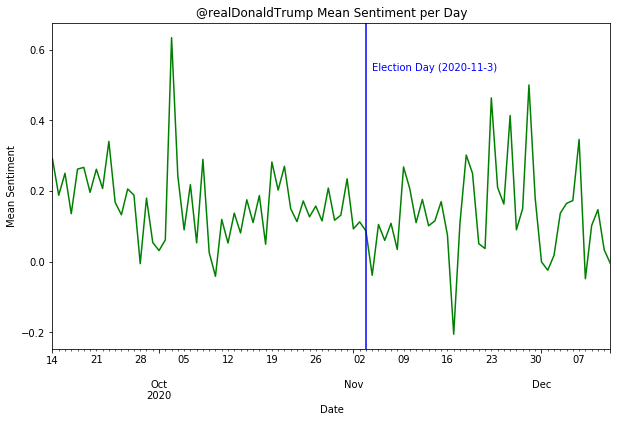

In [236]:
df.groupby(df["date truncated"])["sentiment"].mean().plot(color = "green", figsize = (10, 6))
plt.axvline(x = dt.datetime(2020, 11, 3), color = "blue")
plt.text(dt.datetime(2020, 11, 4), 0.54, "Election Day (2020-11-3)", color = "blue")
plt.title("@realDonaldTrump Mean Sentiment per Day")
plt.xlabel("Date")
plt.ylabel("Mean Sentiment")
plt.savefig("images/mean_sentiment_per_day")

## Word Clouds
Generate word clouds of the most popular words

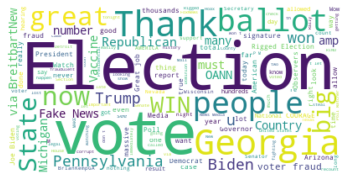

In [238]:
stopwords = set(STOPWORDS)
stopwords.update(["will", "s"])

# Post-election wordcloud
post_wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(" ".join(post_election["text"].tolist()))
post_wordcloud.to_file("images/post_wordcloud.png")

plt.imshow(post_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

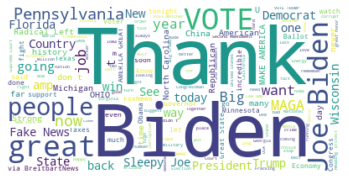

In [239]:
# Pre-election wordcloud
pre_wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(" ".join(pre_election["text"].tolist()))
pre_wordcloud.to_file("images/pre_wordcloud.png")

plt.imshow(pre_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [261]:
# Mean sentiment before and after election day
print("Mean sentiment pre-election: " + str(pre_election["sentiment"].mean()))
print("Mean sentiment post-election: " + str(post_election["sentiment"].mean()))

print("Pre-election sentiment > 0.25: " + str(len(pre_election[pre_election["sentiment"] > 0.25]) / len(pre_election["sentiment"])))
print("Post-election sentiment > 0.25: " + str(len(post_election[post_election["sentiment"] > 0.25]) / len(post_election["sentiment"])))

Mean sentiment pre-election: 0.14972347992622653
Mean sentiment post-election: 0.12157396425692983
Pre-election sentiment > 0.25: 0.3007312614259598
Post-election sentiment > 0.25: 0.2643253234750462
